(284807, 30)
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...   -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ...   -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...    0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ...   -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...   -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Amount  Class  
0  0.066928  0.128539 -0.189115  0

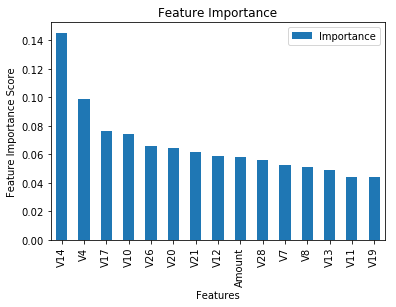

   Features  Importance
0       V14    0.145427
1        V4    0.098951
2       V17    0.076462
3       V10    0.074213
8       V26    0.065967
5       V20    0.064468
7       V21    0.061469
4       V12    0.058471
6    Amount    0.057721
9       V28    0.056222
13       V7    0.052474
12       V8    0.050975
14      V13    0.048726
10      V11    0.044228
11      V19    0.044228
Total Time to Train:  0.6023983359336853


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score

import xgboost as xgb # do "pip install xgboost" to avoid any dependency issue
from xgboost import XGBClassifier

"""
Total shape:
(284807, 31)

1. ----
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

2. ----
All columns are float except the 'class' which is 0/1 int

3. ----
No Missing Value

4. ----
print(df['Class'].value_counts())
print(df['Class'].value_counts()[0]/len(df['Class']) * 100)
print(df['Class'].value_counts()[1]/len(df['Class']) * 100)
0    284315
1       492
Name: Class, dtype: int64
99.82725143693798
0.1727485630620034
"""

def data_process():
    df = pd.read_csv("resource/creditcard.csv")
    df = df.drop("Time", axis=1)
    print(df.shape)
    features_to_select = ['V14', 'V4', 'V17', 'V10', 'V12', 'V20', 'Amount', 'V21', 'V26', 'V28', 'V11', 'V19', 'V8', 'V7', 'V13']
    #print('Use StandardScaler to process the column data')
    scaller = StandardScaler()
    print(df.head(5))
    
    #You scale the features to reduce the variance
    df[df.columns[:-1].tolist()] = scaller.fit_transform(df[df.columns[:-1].tolist()])
    print(df.head(5))
    
    #Features are the all except last col
    X = df[df.columns[:-1].tolist()]
    print("X shape 1:", X.shape)
    
    #Choose only 15 features out of 29 features
    X = X[features_to_select] 
    
    #Labels is the last col
    y = df[df.columns[-1]]
    
    print("Train Test Split ratio is 0.3")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    
    return X_train, X_test, y_train, y_test

def XGB_Classifier(X_train, X_test, y_train, y_test, useTrainCV=False, cv_folds=5, early_stopping_rounds=50):
    
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
 


    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')
    
    print("Start Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]
    
    print("accuracy_score : %.4g" % metrics.accuracy_score(y_test, predictions))
    print("roc_auc_score: %f" % metrics.roc_auc_score(y_test, pred_proba))
    print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)

    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importance')
    
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    print(res_df)
    #print(res_df['Features'].tolist())
    
if __name__ == "__main__":
    
    start = time.time()
    
    X_train, X_test, y_train, y_test = data_process()
    
    XGB_Classifier( X_train, X_test, y_train, y_test)
    
    print("Total Time to Train: ", (time.time() - start)/60)
